In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
import cv2

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize pixel values (0 to 1)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the images from RGB to LAB color space
def rgb_to_lab(images):
    lab_images = []
    for img in images:
        img = (img * 255).astype(np.uint8)
        lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lab_images.append(lab_img)
    return np.array(lab_images)

lab_train = rgb_to_lab(x_train)
lab_test = rgb_to_lab(x_test)

# Split into L channel (grayscale) and A/B channels (color)
x_train_l = lab_train[:, :, :, 0:1]  # L channel
x_train_ab = lab_train[:, :, :, 1:]  # A and B channels

x_test_l = lab_test[:, :, :, 0:1]  # L channel
x_test_ab = lab_test[:, :, :, 1:]  # A and B channels

# Data augmentation setup for L channel (grayscale)
datagen_l = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment L channel images
def augment_images_l(images):
    augmented_images = []
    for img in images:
        img = np.expand_dims(img, axis=0)  # Expand dimensions for ImageDataGenerator
        aug_iter = datagen_l.flow(img, batch_size=1)
        augmented_images.append(next(aug_iter)[0])  # Take the first image from the batch
    return np.array(augmented_images)

# Augment A/B channels similarly but without heavy transformations (to keep color information intact)
datagen_ab = ImageDataGenerator(
    rotation_range=10,   # Lower range for rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment AB channels
# def augment_images_ab(images):
#     augmented_images = []
#     for img in images:
#         img = np.expand_dims(img, axis=0)
#         aug_iter = datagen_ab.flow(img, batch_size=1)
#         augmented_images.append(next(aug_iter)[0])
#     return np.array(augmented_images)

# # Augment training data
# augmented_train_l = augment_images_l(x_train_l)
# augmented_train_ab = augment_images_ab(x_train_ab)

# print(f"Augmented Training L channel shape: {augmented_train_l.shape}")
# print(f"Augmented Training AB channels shape: {augmented_train_ab.shape}")


Augmented Training L channel shape: (50000, 32, 32, 1)
Augmented Training AB channels shape: (50000, 32, 32, 2)


In [22]:
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, ReLU, Concatenate
# from tensorflow.keras.models import Model

# def build_unet(input_shape=(32, 32, 1)):
#     inputs = Input(shape=input_shape)

#     # Encoder
#     c1 = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
#     c1 = BatchNormalization()(c1)
#     c1 = Conv2D(64, (3, 3), padding='same', activation='relu')(c1)

#     c2 = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(c1)
#     c2 = BatchNormalization()(c2)
#     c2 = Conv2D(128, (3, 3), padding='same', activation='relu')(c2)

#     c3 = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(c2)
#     c3 = BatchNormalization()(c3)
#     c3 = Conv2D(256, (3, 3), padding='same', activation='relu')(c3)

#     # Decoder
#     d1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(c3)
#     d1 = BatchNormalization()(d1)

#     d2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(d1)
#     d2 = BatchNormalization()(d2)

#     # Output layer: 2 channels for the AB chrominance
#     outputs = Conv2D(2, (3, 3), padding='same', activation='tanh')(d2)

#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# model = build_unet()
# model.compile(optimizer='adam', loss='mse')
# model.summary()

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization, LeakyReLU, Add, Multiply
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=3, strides=1, padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

def residual_block(x, filters):
    res = x
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    x = Add()([x, res])
    return x

def build_advanced_unet(input_shape=(32, 32, 1)):
    inputs = Input(shape=input_shape)

    # Encoder
    e1 = residual_block(inputs, 64)
    e2 = conv_block(e1, 128, strides=2)
    e3 = conv_block(e2, 256, strides=2)

    # Decoder
    d1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(e3)
    d1 = BatchNormalization()(d1)
    d1 = LeakyReLU()(d1)
    d1 = Add()([d1, e2])  # Skip connection

    d2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU()(d2)
    d2 = Add()([d2, e1])  # Skip connection

    # Output layer: 2 channels for the AB chrominance
    outputs = Conv2D(2, (3, 3), padding='same', activation='tanh')(d2)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_advanced_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 32, 32, 64)     │            640 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 32, 32, 64)     │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 32, 32, 64)     │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 32, 32, 64)     │              0 │ leaky_re_lu_7[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 16, 16, 128)    │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 8, 8, 256)      │          1,024 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_9 (LeakyReLU) │ (None, 8, 8, 256)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 16, 16, 128)    │        295,040 │ leaky_re_lu_9[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 16, 16, 128)    │            512 │ conv2d_transpose_6[0]… │
│ (BatchNormalization) 

 Total params: 779,394 (2.97 MB)

 Trainable params: 777,986 (2.97 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [25]:
import ipywidgets as widgets
from IPython.display import display

slider = widgets.IntSlider(value=5000, min=1, max=x_train.shape[0], step=100, description='Dataset size:', continuous_update=False)

# Display the slider
display(slider)
x_train_l = x_train_l.astype(np.float32) / 255.0
x_train_ab = x_train_ab.astype(np.float32) / 255.0
x_test_l = x_test_l.astype(np.float32) / 255.0
x_test_ab = x_test_ab.astype(np.float32) / 255.0

# Function to update the dataset based on slider value
def update_dataset(slider_value):
    global selected_train_l, selected_train_ab # Declare variables as global
    selected_train_l = x_train_l[:slider_value]
    selected_train_ab = x_train_ab[:slider_value]
    # selected_augmented_train_l = augment_images_l(selected_train_l)
    # selected_augmented_train_ab = augment_images_ab(selected_train_ab)

    selected_test_l = x_test_l[:slider_value]
    selected_test_ab = x_test_ab[:slider_value]
    # selected_augmented_test_l = augment_images_l(selected_test_l)
    # selected_augmented_test_ab = augment_images_ab(selected_test_ab)
    # print(f"Selected Training L channel shape: {selected_augmented_train_l.shape}")
    # print(f"Selected Training AB channels shape: {selected_augmented_train_ab.shape}")

# Link the slider to the function
slider.observe(lambda change: update_dataset(change['new']), names='value')

update_dataset(slider.value) # Call the function to initialize variables

history = model.fit(
    selected_train_l, selected_train_ab,
    epochs=10,
    batch_size=16,
    validation_data=(x_test_l[:1000],x_test_l[:1000])
)

from google.colab import files
model.save("colorization_unet_cifar10.h5")
# Download the model file
files.download("colorization_unet_cifar10.h5")

IntSlider(value=5000, continuous_update=False, description='Dataset size:', max=50000, min=1, step=100)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 111s 355ms/step - loss: 0.0388 - val_loss: 0.0501
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 348ms/step - loss: 0.0037 - val_loss: 0.0136
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 353ms/step - loss: 0.0025 - val_loss: 0.0695
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 350ms/step - loss: 0.0022 - val_loss: 0.0072
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 351ms/step - loss: 9.1730e-04 - val_loss: 0.0051
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 349ms/step - loss: 5.7937e-04 - val_loss: 0.0045
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 354ms/step - loss: 3.9439e-04 - val_loss: 0.0317
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 349ms/step - loss: 3.9281e-04 - val_loss: 0.0021
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 353ms/step - loss: 2.8831e-04 - val_loss: 0.0105
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 349ms/step - loss: 2.4739e-04 - val_loss: 0.0080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:

# history = model.fit(
#     selected_train_l, selected_train_ab,
#     epochs=50,
#     batch_size=128,
#     validation_data=(x_test_l, x_test_ab)
# )

# from google.colab import files
# model.save("colorization_unet_cifar10.h5")
# # Download the model file
# files.download("colorization_unet_cifar10.h5")


NameError: name 'selected_train_l' is not defined

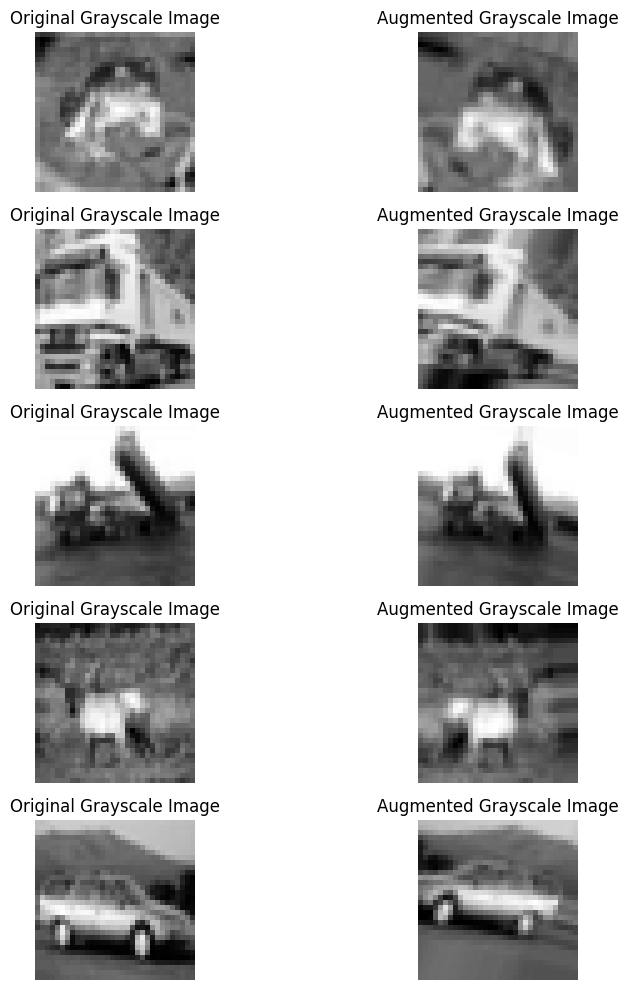

In [26]:
import matplotlib.pyplot as plt

def plot_images(original_images, augmented_images, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

    for i in range(num_images):
        # Display original grayscale image
        axes[i, 0].imshow(original_images[i].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Grayscale Image')
        axes[i, 0].axis('off')

        # Display augmented grayscale image
        axes[i, 1].imshow(augmented_images[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Augmented Grayscale Image')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Select a subset of images from the original and augmented datasets
original_subset_l = x_train_l[:5]  # Adjust the number if needed
augmented_subset_l = augmented_train_l[:5]  # Corresponding augmented images

# Plot the images
plot_images(original_subset_l, augmented_subset_l)


In [27]:
# Generate predictions
predictions = model.predict(x_test_l[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


In [28]:
def denormalize_images(normalized_images):
    return (normalized_images * 255.0).astype(np.uint8)

# Denormalize predictions
denormalized_predictions = denormalize_images(predictions)

In [31]:
denormalized_predictions

array([[[[ 42,  48],
         [ 45,  11],
         [ 58,  17],
         [ 16, 226]],

        [[ 18, 111],
         [ 97,  61],
         [ 82,  37],
         [ 75, 218]],

        [[ 47, 108],
         [108,  25],
         [111,  28],
         [ 78, 198]],

        ...,

        [[ 48, 101],
         [117,  39],
         [114,  20],
         [ 83, 193]],

        [[ 30, 102],
         [110,  34],
         [108,  34],
         [ 86, 208]],

        [[ 10,  76],
         [ 58,  54],
         [ 66,  43],
         [ 53, 236]]],


       [[[ 42,  48],
         [ 45,  11],
         [ 59,  17],
         [ 16, 226]],

        [[ 17, 110],
         [ 96,  60],
         [ 82,  37],
         [ 75, 218]],

        [[ 47, 108],
         [108,  24],
         [111,  27],
         [ 78, 198]],

        ...,

        [[ 48, 100],
         [117,  38],
         [114,  19],
         [ 83, 193]],

        [[ 30, 101],
         [110,  34],
         [108,  33],
         [ 86, 208]],

        [[ 10,  76],
   

In [29]:
def combine_l_and_ab(l_channel, ab_channel):
    combined = np.concatenate([l_channel, ab_channel], axis=-1)
    return combined

# Combine grayscale L with predicted AB channels
colorized_images = combine_l_and_ab(x_test_l, denormalized_predictions)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10000 and the array at index 1 has size 32

In [33]:
print("Shape of x_test_l:", x_test_l[1].shape)
print("Shape of denormalized_predictions:", denormalized_predictions.shape)

Shape of x_test_l: (32, 32, 1)
Shape of denormalized_predictions: (32, 32, 4, 2)
